In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import networkx as nx



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.7.0+cu101


In [2]:
drive.mount('/content/drive')
folder_dir = '/content/drive/My Drive/cora'

Mounted at /content/drive


In [7]:
class Cora(object):
    
    def __init__(self, base_dir):
        data = np.genfromtxt(base_dir + '/cora/cora.content', dtype=np.str)
        

        self.category_list = list(set(data[:, -1]))
        self.cat2lab = {category:label for label, category in enumerate(self.category_list)}
        self.lab2cat = {label:category for label, category in enumerate(self.category_list)}
        
        self.paper_list = np.array(data[:, 0], dtype=np.int)
        self.paper2node = {paper_id:node_id for node_id, paper_id in enumerate(self.paper_list)}
        self.node2paper = {node_id:paper_id for node_id, paper_id in enumerate(self.paper_list)}


        self.node_feature = np.array(data[:, 1:-1], dtype=int)
        self.node_label = [self.cat2lab[category] for category in data[:, -1]]
        
        edge = np.genfromtxt(base_dir + '/cora/cora.cites',   dtype=np.int)
        
        node_connection = np.empty_like(edge)
        self.node_adj = np.zeros((data.shape[0], data.shape[0]), dtype=np.bool)

        for i, (cited, citing) in enumerate(edge):
            node_connection[i] = (self.paper2node[cited], self.paper2node[citing])
            self.node_adj[node_connection[i][0]][node_connection[i][1]] = True
            self.node_adj[node_connection[i][1]][node_connection[i][0]] = True
            self.node_adj[node_connection[i][0]][node_connection[i][0]] = True # A + I
            self.node_adj[node_connection[i][1]][node_connection[i][1]] = True



    def get_dataset(self):

        node_x = np.array(self.node_feature, dtype=np.int32)
        node_y = np.array(self.node_label, dtype=np.int32)
        adjmat = np.array(self.node_adj, dtype=np.bool)
        return node_x, node_y, adjmat
        

cora = Cora(base_dir='/content/drive/My Drive')



node_x, node_y, adjmat = cora.get_dataset()


In [8]:
def xavier_weight(*size):
    return torch.nn.init.xavier_uniform_(torch.empty(*size))





class GraphAttentionLayer(nn.Module):
    def __init__(self, n_in, n_head, n_feature):
        super().__init__()

        self.n_head = n_head
        self.n_feature = n_feature
        self.weight = nn.Parameter(xavier_weight(n_in, n_head * n_feature))
        self.a_proj = nn.Parameter(xavier_weight(n_head, 2 * n_feature))

    def forward(self, x, mask):
        n_node = x.size(0)
        x = (x @ self.weight).view(n_node, self.n_head, self.n_feature)

        out = []
        for i in range(self.n_head):
            x_i = x[:, i, :] # [N, F']
            
            x_i_vals = x_i.unsqueeze(dim=0).expand(n_node, -1, -1) # [N, N, F']
            a = torch.cat([ x_i.unsqueeze(dim=1).expand(-1, n_node, -1),  x_i_vals], dim=2) * self.a_proj[i] # [N, N, 2 * F']
            a = a.sum(dim=2) # [N, N]

            a = F.leaky_relu(a, negative_slope=0.2)



            a = a.masked_fill(mask, -np.inf)
            a = torch.softmax(a, dim=1)
            a = a.unsqueeze(dim=2) * x_i_vals # [N, N, F']
            a = a.sum(dim=1) # [N, F']
            out.append(a)
        

        out = torch.cat(out, dim=1)
        return out





class GATBlock(nn.Module):
    def __init__(self, n_in, n_head, n_feature, p):
        super().__init__()
        self.gat = GraphAttentionLayer(n_in, n_head, n_feature)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p) 
        
    def forward(self, x, mask):
        x = self.gat(x, mask)
        x = self.dropout(x)
        x = self.act(x)
        return x


class GAT(nn.Module):
    def __init__(self, n_in, n_head, n_feature, n_out):
        super().__init__()

        self.n_head = n_head
        n_hid = n_head * n_feature
        self.layer_in = nn.Sequential(nn.Linear(n_in, n_hid), nn.ELU(), nn.Dropout(0.6))
        self.layer = nn.ModuleList([
            GATBlock(n_hid, n_head, n_feature, 0.6),
            GATBlock(n_hid, n_head, n_feature, 0.6)
        ])        
        self.layer_out = nn.Linear(n_hid, n_out)

    
    def forward(self, x, mask):

        x = self.layer_in(x)
        for gat in self.layer:
            x = gat(x, mask)
        x = self.layer_out(x)
        return x



In [9]:
adj = torch.from_numpy(adjmat).bool()
X = torch.Tensor(node_x.astype(np.float))
X = X / X.sum(dim=1, keepdim=True)
target = torch.LongTensor(node_y)

In [11]:
idx_train = range(200)
idx_test = range(200, len(X))
idx_train = torch.LongTensor(idx_train)
idx_test = torch.LongTensor(idx_test)
mask = adj == False
model = GAT(n_in=len(node_x[0]), n_head=8, n_feature=8, n_out=7)
solver = optim.Adam(model.parameters(),  lr=1e-2, weight_decay=1e-6)

In [12]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(100):
    solver.zero_grad()
    Y = model(X, mask)
    loss = F.cross_entropy(Y[idx_train], target[idx_train], reduction='mean')
    loss.backward()
    solver.step()
    print(loss.item())
    with torch.no_grad():
        model.eval()
        Y = model(X, mask)
        train_loss.append(F.cross_entropy(Y[idx_train], target[idx_train], reduction='mean').item())
        test_loss.append(F.cross_entropy(Y[idx_test], target[idx_test], reduction='mean').item())
        train_acc.append((Y[idx_train].argmax(dim=1) == target[idx_train]).sum().item() / len(idx_train))
        test_acc.append((Y[idx_test].argmax(dim=1) == target[idx_test]).sum().item() / len(idx_test))
        model.train()


1.9622470140457153
1.9367356300354004
1.9005725383758545
1.8324172496795654
1.798205852508545
1.8370709419250488
1.745457410812378
1.7191226482391357
1.666614055633545
1.6067843437194824
1.5345088243484497
1.4435648918151855
1.2743308544158936
1.1513431072235107
1.0096487998962402
0.9214087128639221
0.8203809261322021
0.7468747496604919
0.6719173192977905
0.5513262152671814
0.507213830947876
0.4455849528312683
0.4162493944168091
0.35937708616256714
0.3172731399536133
0.26851990818977356
0.20154811441898346
0.16079990565776825
0.13341321051120758
0.16430039703845978
0.19558319449424744
0.09364596009254456
0.12285379320383072
0.12565991282463074
0.1194232776761055
0.11284711956977844
0.09416471421718597
0.12093751132488251
0.10553696751594543
0.05500449612736702
0.04638848826289177
0.09226837754249573
0.060659050941467285
0.06075068563222885
0.05874185636639595
0.04907122254371643
0.07077507674694061
0.09299281984567642
0.06071482226252556
0.04932575300335884
0.026793222874403
0.05236838

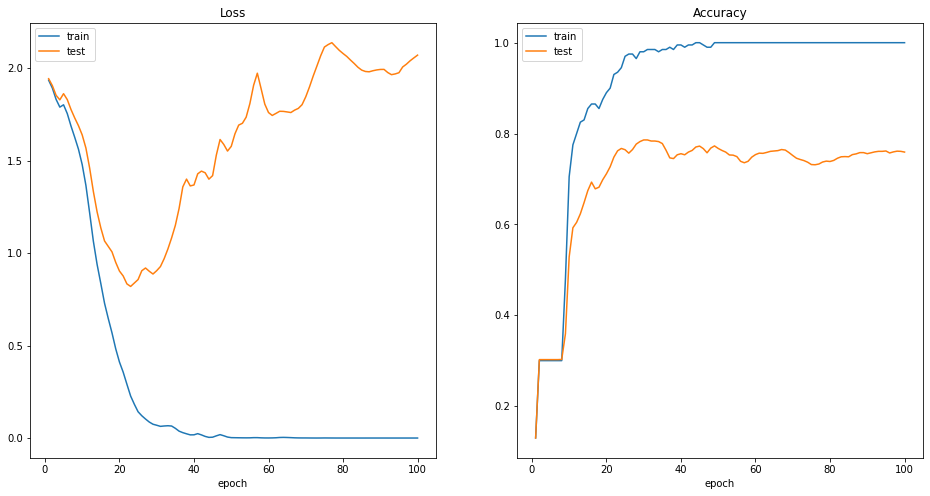

train loss :  2.1829646357218735e-05
test loss :  2.0697968006134033
train accuracy :  1.0
test accuracy :  0.759170653907496


In [14]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(range(1, len(train_loss) + 1), train_loss, label='train')
ax.plot(range(1, len(test_acc) + 1), test_loss, label='test')

ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.legend()

ax = f.add_subplot(1,2,2)
ax.plot(range(1, len(train_acc) + 1), train_acc, label='train')
ax.plot(range(1, len(test_acc) + 1), test_acc, label='test')
ax.set_title('Accuracy')
ax.set_xlabel('epoch')

ax.legend()
plt.show()
print('train loss : ', train_loss[-1])
print('test loss : ', test_loss[-1])
print('train accuracy : ', train_acc[-1])
print('test accuracy : ', test_acc[-1])